In [1]:
import os

# Walk through  directory and list number of files
for dirpath, dirnames, filenames in os.walk("/kaggle/input/diagnosis-of-diabetic-retinopathy/Diagnosis of Diabetic Retinopathy/train"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")



There are 2 directories and 0 images in '/kaggle/input/diagnosis-of-diabetic-retinopathy/Diagnosis of Diabetic Retinopathy/train'.
There are 0 directories and 1050 images in '/kaggle/input/diagnosis-of-diabetic-retinopathy/Diagnosis of Diabetic Retinopathy/train/DR'.
There are 0 directories and 1026 images in '/kaggle/input/diagnosis-of-diabetic-retinopathy/Diagnosis of Diabetic Retinopathy/train/No_DR'.


In [2]:
import numpy as np 
import os
import keras
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from PIL import Image
from keras.layers import Conv2D,Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split


In [3]:
import pathlib
import numpy as np
data_dir = pathlib.Path("/kaggle/input/diagnosis-of-diabetic-retinopathy/Diagnosis of Diabetic Retinopathy/train") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['DR' 'No_DR']


In [4]:
class_labels = ['DR','No_DR']


In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img


Image shape: (224, 224, 3)


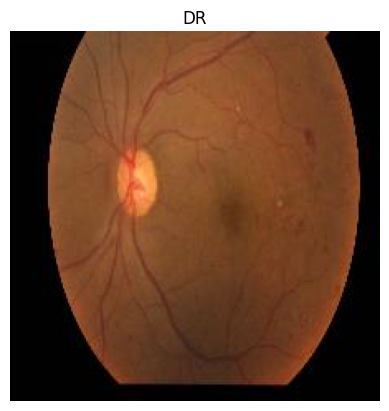

In [6]:
img = view_random_image(target_dir="/kaggle/input/diagnosis-of-diabetic-retinopathy/Diagnosis of Diabetic Retinopathy/train/",
                        target_class="DR")

In [7]:
img.shape

(224, 224, 3)

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_size=[224,224]

# Set the seed
tf.random.set_seed(42)
# Setup the train and test directories
train_dir = "/kaggle/input/diagnosis-of-diabetic-retinopathy/Diagnosis of Diabetic Retinopathy/train"
valid_dir = "/kaggle/input/diagnosis-of-diabetic-retinopathy/Diagnosis of Diabetic Retinopathy/valid"
test_dir = "/kaggle/input/diagnosis-of-diabetic-retinopathy/Diagnosis of Diabetic Retinopathy/test"
# Preprocess data with validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
      # Specify validation split
)

valid_datagen = ImageDataGenerator(
    rescale=1./255,
     # Specify validation split for validation generator
)
test_datagen = ImageDataGenerator(rescale=1./255)
# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(
    train_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode="categorical",
    color_mode="rgb",
    shuffle=True,
    subset='training',  # Use training subset
    seed=42
)

validation_data = valid_datagen.flow_from_directory(
    valid_dir ,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode="rgb",
    shuffle=False,
    # Use validation subset
    seed=42
)
test_data = test_datagen.flow_from_directory(
    test_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode="categorical",
    shuffle=False,
    seed=42
)



Found 2076 images belonging to 2 classes.
Found 531 images belonging to 2 classes.
Found 231 images belonging to 2 classes.


In [9]:
img= train_data[0]
print(f'Train data type: {type(train_data )}')
print(f'Train data shape: {train_data [0][0].shape}')
print(f'Train classes: {img[1].shape}')

img= validation_data[0]
print(f'\nValid. data type: {type(validation_data )}')
print(f'Valid. data shape: {validation_data [0][0].shape}')
print(f'Valid. classes: {img[1].shape}')

img= test_data[0]
print(f'\nTest data type: {type(test_data )}')
print(f'Test data shape: {test_data [0][0].shape}')
print(f'Test classes: {img[1].shape}')

Train data type: <class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>
Train data shape: (32, 224, 224, 3)
Train classes: (32, 2)

Valid. data type: <class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>
Valid. data shape: (32, 224, 224, 3)
Valid. classes: (32, 2)

Test data type: <class 'keras.src.legacy.preprocessing.image.DirectoryIterator'>
Test data shape: (32, 224, 224, 3)
Test classes: (32, 2)


In [10]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model

BATCH_SIZE = 32
IMAGE_SIZE = [224, 224]
CHANNELS = 3

# Load the base model (VGG19)
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers
x = Flatten()(base_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
#x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(2, activation='softmax')(x)  # Multi-class classification with 2 classes

# Final model
model_vgg19 = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model_vgg19.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model_vgg19.summary()


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,78

 Total params: 26,447,682 (100.89 MB)

 Trainable params: 6,423,298 (24.50 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [11]:
history = model_vgg19.fit(
    train_data,
    epochs=5,  # You can adjust the number of epochs
    validation_data=validation_data
)


Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


65/65 ━━━━━━━━━━━━━━━━━━━━ 850s 13s/step - accuracy: 0.7408 - loss: 1.5540 - val_accuracy: 0.8889 - val_loss: 0.3479
Epoch 2/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 875s 13s/step - accuracy: 0.9213 - loss: 0.2356 - val_accuracy: 0.9134 - val_loss: 0.3044
Epoch 3/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 842s 13s/step - accuracy: 0.9012 - loss: 0.2667 - val_accuracy: 0.9228 - val_loss: 0.1992
Epoch 4/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 896s 13s/step - accuracy: 0.8964 - loss: 0.2633 - val_accuracy: 0.9171 - val_loss: 0.2301
Epoch 5/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 875s 13s/step - accuracy: 0.9248 - loss: 0.2157 - val_accuracy: 0.9153 - val_loss: 0.2275


In [12]:
test_loss, test_accuracy = model_vgg19.evaluate(test_data)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 73s 9s/step - accuracy: 0.9084 - loss: 0.2750
Test Loss: 0.22755739092826843, Test Accuracy: 0.9264069199562073


In [13]:
import matplotlib.pyplot as plt
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();



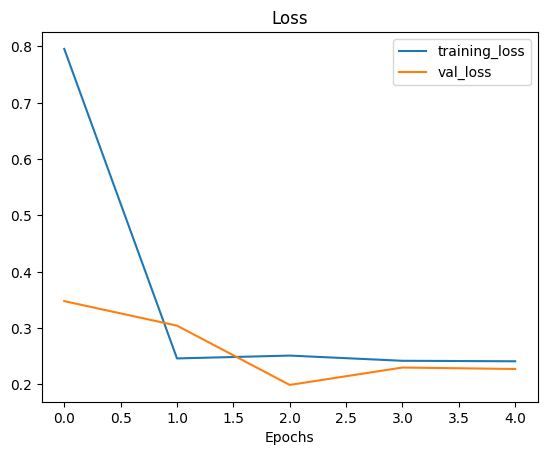

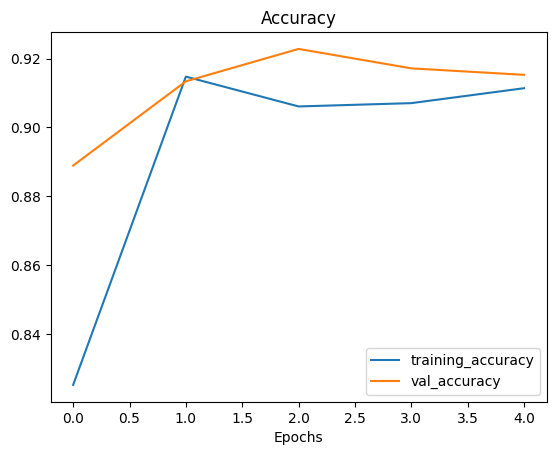

In [14]:
plot_loss_curves(history)

In [15]:
model_vgg19.save('Diabetic.h5')

In [16]:
def load_and_prep_image(filename, img_shape=224):
    """
    Reads an image from filename, turns it into a tensor
    and reshapes it to (img_shape, img_shape, colour_channel).
    """
    # Read in target file (an image)
    img = tf.io.read_file(filename)

    # Decode the read file into a tensor & ensure 3 colour channels
    img = tf.image.decode_image(img, channels=3)

    # Resize the image (to the same size our model was trained on)
    img = tf.image.resize(img, size=[img_shape, img_shape])

    # Rescale the image (get all values between 0 and 1)
    img = img / 255.

    # Add batch dimension (model expects shape (batch_size, height, width, channels))
    img = tf.expand_dims(img, axis=0)
    
    return img

In [17]:
test = load_and_prep_image("/kaggle/input/diagnosis-of-diabetic-retinopathy/retino/test/No_DR/08ee569d4721_png.rf.c2dd739bc62b7eb644f782b9c03f6a77.jpg")

In [18]:
import tensorflow as tf
import numpy as np
# Your class labels
class_labels = ['DR','No_DR']

saved_model = tf.keras.models.load_model('/kaggle/working/Diabetic.h5')

# Make a prediction on our custom image
prediction=saved_model.predict(test)
predicted_class = np.argmax(prediction, axis=-1)

# Map the predicted class index to the class label
predicted_class_label = class_labels[predicted_class[0]]

print(f"Predicted class: {predicted_class_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step
Predicted class: No_DR


Found 2076 images belonging to 2 classes.
Found 531 images belonging to 2 classes.
Found 231 images belonging to 2 classes.


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 

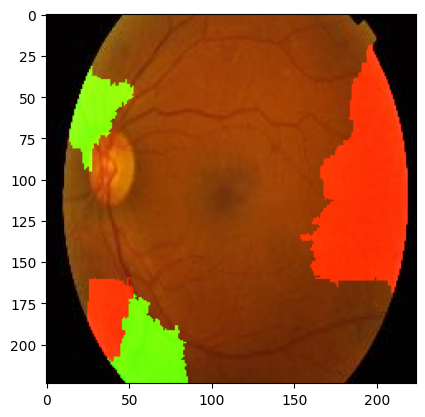

In [19]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_size=[224,224]
import tensorflow as tf
import numpy as np

from lime import lime_image
import matplotlib.pyplot as plt

# Set the seed
tf.random.set_seed(42)
# Setup the train and test directories
train_dir = "/kaggle/input/diagnosis-of-diabetic-retinopathy/Diagnosis of Diabetic Retinopathy/train"
valid_dir = "/kaggle/input/diagnosis-of-diabetic-retinopathy/Diagnosis of Diabetic Retinopathy/valid"
test_dir = "/kaggle/input/diagnosis-of-diabetic-retinopathy/Diagnosis of Diabetic Retinopathy/test"
# Preprocess data with validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
      # Specify validation split
)

valid_datagen = ImageDataGenerator(
    rescale=1./255,
     # Specify validation split for validation generator
)
test_datagen = ImageDataGenerator(rescale=1./255)
# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(
    train_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode="categorical",
    color_mode="rgb",
    shuffle=True,
    subset='training',  # Use training subset
    seed=42
)

validation_data = valid_datagen.flow_from_directory(
    valid_dir ,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode="rgb",
    shuffle=False,
    # Use validation subset
    seed=42
)
test_data = test_datagen.flow_from_directory(
    test_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode="categorical",
    shuffle=False,
    seed=42
)
saved_model = tf.keras.models.load_model('/kaggle/working/Diabetic.h5')
image_shape = (224,224, 3)

explainer = lime_image.LimeImageExplainer()

# Get a single image and its true label
x_test, y_test = next(test_data)
image = x_test[0]  # Take the first image in the batch

# Define the predict function for LIME
def predict_fn(images):
    # Normalize images (to match model preprocessing)
    images = images / 255.0  # Ensures images are between 0 and 1
    return saved_model.predict(images)

# Explain the model's prediction on the first image
explanation = explainer.explain_instance(image.astype('double'), predict_fn, top_labels=5, hide_color=0, num_samples=1000)

# Visualize the explanation for the top class
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)

# Display the mask overlaid on the image
plt.imshow(temp)
plt.show()

In [20]:
from sklearn.metrics import classification_report
import numpy as np

# Get predictions for the test dataset
y_pred_probs = model_vgg19.predict(test_data)  # Predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)       # Convert probabilities to class predictions

# Get true labels
y_true = test_data.classes  # True labels

# Class labels (use test_data.class_indices to map indices to class names if needed)
class_labels = list(test_data.class_indices.keys())

# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_labels, digits=4)
print(report)


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 76s 9s/step
              precision    recall  f1-score   support

          DR     0.9615    0.8850    0.9217       113
       No_DR     0.8976    0.9661    0.9306       118

    accuracy                         0.9264       231
   macro avg     0.9296    0.9255    0.9261       231
weighted avg     0.9289    0.9264    0.9262       231



In [21]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3
BATCH_SIZE = 32
IMAGE_SIZE = [224, 224]
CHANNELS = 3

# Load the base model (VGG19)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers
x = Flatten()(base_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
#x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(2, activation='softmax')(x)  # Multi-class classification with 2 classes

# Final model
model_incepV3 = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model_incepV3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model_incepV3.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 34,910,754 (133.17 MB)

 Trainable params: 13,107,970 (50.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [22]:
history = model_incepV3.fit(
    train_data,
    epochs=5,  # You can adjust the number of epochs
    validation_data=validation_data
)


Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


65/65 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.7247 - loss: 10.0501 - val_accuracy: 0.8719 - val_loss: 0.3059
Epoch 2/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.9020 - loss: 0.2691 - val_accuracy: 0.9266 - val_loss: 0.1831
Epoch 3/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 170s 3s/step - accuracy: 0.9187 - loss: 0.2230 - val_accuracy: 0.9134 - val_loss: 0.1891
Epoch 4/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.9250 - loss: 0.2211 - val_accuracy: 0.8983 - val_loss: 0.2528
Epoch 5/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.9259 - loss: 0.2109 - val_accuracy: 0.9360 - val_loss: 0.1744


In [23]:
test_loss, test_accuracy = model_incepV3.evaluate(test_data)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9385 - loss: 0.1867
Test Loss: 0.17509031295776367, Test Accuracy: 0.9437229633331299


In [24]:
import matplotlib.pyplot as plt
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();



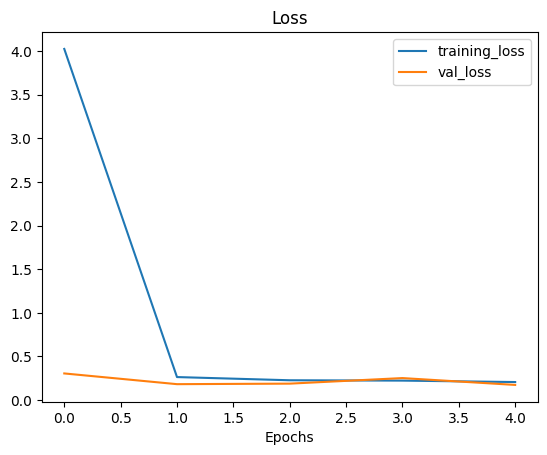

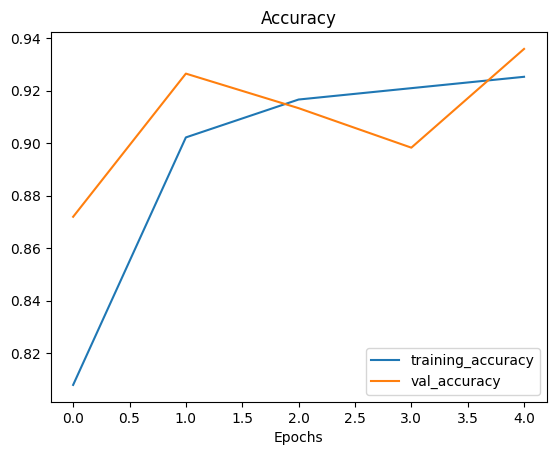

In [25]:
plot_loss_curves(history)

In [26]:
model_incepV3.save('Diabetic1.h5')

In [27]:
def load_and_prep_image(filename, img_shape=224):
    """
    Reads an image from filename, turns it into a tensor
    and reshapes it to (img_shape, img_shape, colour_channel).
    """
    # Read in target file (an image)
    img = tf.io.read_file(filename)

    # Decode the read file into a tensor & ensure 3 colour channels
    img = tf.image.decode_image(img, channels=3)

    # Resize the image (to the same size our model was trained on)
    img = tf.image.resize(img, size=[img_shape, img_shape])

    # Rescale the image (get all values between 0 and 1)
    img = img / 255.

    # Add batch dimension (model expects shape (batch_size, height, width, channels))
    img = tf.expand_dims(img, axis=0)
    
    return img

In [28]:
test = load_and_prep_image("/kaggle/input/diagnosis-of-diabetic-retinopathy/Diagnosis of Diabetic Retinopathy/test/DR/03747397839f_png.rf.b634cf9fb09372b2c9c6bc6616bd5d7c.jpg")

In [29]:
import tensorflow as tf
import numpy as np
# Your class labels
class_labels = ['DR','No_DR']

saved_model = tf.keras.models.load_model('/kaggle/working/Diabetic1.h5')

# Make a prediction on our custom image
prediction=saved_model.predict(test)
predicted_class = np.argmax(prediction, axis=-1)

# Map the predicted class index to the class label
predicted_class_label = class_labels[predicted_class[0]]

print(f"Predicted class: {predicted_class_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted class: DR


Found 2076 images belonging to 2 classes.
Found 531 images belonging to 2 classes.
Found 231 images belonging to 2 classes.


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

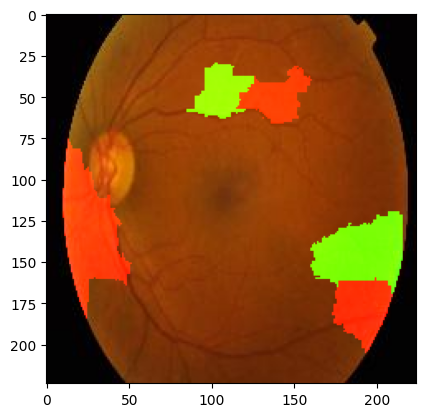

In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_size=[224,224]
import tensorflow as tf
import numpy as np

from lime import lime_image
import matplotlib.pyplot as plt

# Set the seed
tf.random.set_seed(42)
# Setup the train and test directories
train_dir = "/kaggle/input/diagnosis-of-diabetic-retinopathy/Diagnosis of Diabetic Retinopathy/train"
valid_dir = "/kaggle/input/diagnosis-of-diabetic-retinopathy/Diagnosis of Diabetic Retinopathy/valid"
test_dir = "/kaggle/input/diagnosis-of-diabetic-retinopathy/Diagnosis of Diabetic Retinopathy/test"
# Preprocess data with validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
      # Specify validation split
)

valid_datagen = ImageDataGenerator(
    rescale=1./255,
     # Specify validation split for validation generator
)
test_datagen = ImageDataGenerator(rescale=1./255)
# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(
    train_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode="categorical",
    color_mode="rgb",
    shuffle=True,
    subset='training',  # Use training subset
    seed=42
)

validation_data = valid_datagen.flow_from_directory(
    valid_dir ,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode="rgb",
    shuffle=False,
    # Use validation subset
    seed=42
)
test_data = test_datagen.flow_from_directory(
    test_dir,
    batch_size=32,
    target_size=(224, 224),
    class_mode="categorical",
    shuffle=False,
    seed=42
)
saved_model = tf.keras.models.load_model('/kaggle/working/Diabetic1.h5')
image_shape = (224,224, 3)

explainer = lime_image.LimeImageExplainer()

# Get a single image and its true label
x_test, y_test = next(test_data)
image = x_test[0]  # Take the first image in the batch

# Define the predict function for LIME
def predict_fn(images):
    # Normalize images (to match model preprocessing)
    images = images / 255.0  # Ensures images are between 0 and 1
    return saved_model.predict(images)

# Explain the model's prediction on the first image
explanation = explainer.explain_instance(image.astype('double'), predict_fn, top_labels=5, hide_color=0, num_samples=1000)

# Visualize the explanation for the top class
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)

# Display the mask overlaid on the image
plt.imshow(temp)
plt.show()

In [31]:
from sklearn.metrics import classification_report
import numpy as np

# Get predictions for the test dataset
y_pred_probs = model_incepV3.predict(test_data)  # Predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)       # Convert probabilities to class predictions

# Get true labels
y_true = test_data.classes  # True labels

# Class labels (use test_data.class_indices to map indices to class names if needed)
class_labels = list(test_data.class_indices.keys())

# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_labels, digits=4)
print(report)


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step
              precision    recall  f1-score   support

          DR     0.9545    0.9292    0.9417       113
       No_DR     0.9339    0.9576    0.9456       118

    accuracy                         0.9437       231
   macro avg     0.9442    0.9434    0.9437       231
weighted avg     0.9440    0.9437    0.9437       231

